# This is a notebook that shows how to produce Grad-CAM visualizations for ALBEF

# 1. Set the paths for model checkpoint and configuration

In [1]:
# model_path = '/mnt/sda/lpf/codes/M2I2/pre_weights/mim_pre_med/med_pretrain_29.pth'
model_path = '/mnt/sda/lpf/codes/mimtc/output/rad-74.06-32-384/med_pretrain_29_rad_32.pth'
bert_config_path = '/mnt/sda/lpf/codes/mimtc/configs/config_bert.json'
use_cuda = False

# 2. Model defination

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.vision_transformer import _cfg, PatchEmbed
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_, DropPath


class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.attn_gradients = None
        self.attention_map = None

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    def save_attention_map(self, attention_map):
        self.attention_map = attention_map

    def get_attention_map(self):
        return self.attention_map

    def forward(self, x, register_hook=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        if register_hook:
            self.save_attention_map(attn)
            attn.register_hook(self.save_attn_gradients)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, register_hook=False):
        x = x + self.drop_path(self.attn(self.norm1(x), register_hook=register_hook))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`  -
        https://arxiv.org/abs/2010.11929
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, representation_size=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward(self, x, register_blk=-1):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.pos_drop(x)

        for i, blk in enumerate(self.blocks):
            x = blk(x, register_blk == i)
        x = self.norm(x)

        return x


def interpolate_pos_embed(pos_embed_checkpoint, visual_encoder):
    # interpolate position embedding
    embedding_size = pos_embed_checkpoint.shape[-1]
    num_patches = visual_encoder.patch_embed.num_patches
    num_extra_tokens = visual_encoder.pos_embed.shape[-2] - num_patches
    # height (== width) for the checkpoint position embedding
    orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
    # height (== width) for the new position embedding
    new_size = int(num_patches ** 0.5)

    if orig_size != new_size:
        # class_token and dist_token are kept unchanged
        extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
        # only the position tokens are interpolated
        pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
        pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
        pos_tokens = torch.nn.functional.interpolate(
            pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
        pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
        new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
        print('reshape position embedding from %d to %d' % (orig_size ** 2, new_size ** 2))

        return new_pos_embed
    else:
        return pos_embed_checkpoint

In [3]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch BERT model. """

import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
from torch import Tensor, device, dtype, nn
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn.functional as F

from transformers.activations import ACT2FN
from transformers.file_utils import (
    ModelOutput,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    replace_return_docstrings,
)
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    NextSentencePredictorOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)
from transformers.modeling_utils import (
    PreTrainedModel,
    apply_chunking_to_forward,
    find_pruneable_heads_and_indices,
    prune_linear_layer,
)
from transformers.utils import logging
from transformers.models.bert.configuration_bert import BertConfig

import transformers

transformers.logging.set_verbosity_error()

logger = logging.get_logger(__name__)

_CONFIG_FOR_DOC = "BertConfig"
_TOKENIZER_FOR_DOC = "BertTokenizer"

BERT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "bert-base-uncased",
    "bert-large-uncased",
    "bert-base-cased",
    "bert-large-cased",
    "bert-base-multilingual-uncased",
    "bert-base-multilingual-cased",
    "bert-base-chinese",
    "bert-base-german-cased",
    "bert-large-uncased-whole-word-masking",
    "bert-large-cased-whole-word-masking",
    "bert-large-uncased-whole-word-masking-finetuned-squad",
    "bert-large-cased-whole-word-masking-finetuned-squad",
    "bert-base-cased-finetuned-mrpc",
    "bert-base-german-dbmdz-cased",
    "bert-base-german-dbmdz-uncased",
    "cl-tohoku/bert-base-japanese",
    "cl-tohoku/bert-base-japanese-whole-word-masking",
    "cl-tohoku/bert-base-japanese-char",
    "cl-tohoku/bert-base-japanese-char-whole-word-masking",
    "TurkuNLP/bert-base-finnish-cased-v1",
    "TurkuNLP/bert-base-finnish-uncased-v1",
    "wietsedv/bert-base-dutch-cased",
    # See all BERT models at https://huggingface.co/models?filter=bert
]


def load_tf_weights_in_bert(model, config, tf_checkpoint_path):
    """Load tf checkpoints in a pytorch model."""
    try:
        import re

        import numpy as np
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array)

    for name, array in zip(names, arrays):
        name = name.split("/")
        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
                n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
                for n in name
        ):
            logger.info("Skipping {}".format("/".join(name)))
            continue
        pointer = model
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+_\d+", m_name):
                scope_names = re.split(r"_(\d+)", m_name)
            else:
                scope_names = [m_name]
            if scope_names[0] == "kernel" or scope_names[0] == "gamma":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "output_bias" or scope_names[0] == "beta":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "output_weights":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "squad":
                pointer = getattr(pointer, "classifier")
            else:
                try:
                    pointer = getattr(pointer, scope_names[0])
                except AttributeError:
                    logger.info("Skipping {}".format("/".join(name)))
                    continue
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]
        if m_name[-11:] == "_embeddings":
            pointer = getattr(pointer, "weight")
        elif m_name == "kernel":
            array = np.transpose(array)
        try:
            assert (
                    pointer.shape == array.shape
            ), f"Pointer shape {pointer.shape} and array shape {array.shape} mismatched"
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        logger.info("Initialize PyTorch weight {}".format(name))
        pointer.data = torch.from_numpy(array)
    return model


class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")

        self.config = config

    def forward(
            self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length: seq_length + past_key_values_length]

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertSelfAttention(nn.Module):
    def __init__(self, config, is_cross_attention):
        super().__init__()
        self.config = config
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        if is_cross_attention:
            self.key = nn.Linear(config.encoder_width, self.all_head_size)
            self.value = nn.Linear(config.encoder_width, self.all_head_size)
        else:
            self.key = nn.Linear(config.hidden_size, self.all_head_size)
            self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)
        self.save_attention = False

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    def save_attention_map(self, attention_map):
        self.attention_map = attention_map

    def get_attention_map(self):
        return self.attention_map

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
            self,
            hidden_states,
            attention_mask=None,
            head_mask=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_value=None,
            output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        if is_cross_attention and self.save_attention:
            self.save_attention_map(attention_probs)
            attention_probs.register_hook(self.save_attn_gradients)

            # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_dropped = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs_dropped = attention_probs_dropped * head_mask

        context_layer = torch.matmul(attention_probs_dropped, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        outputs = outputs + (past_key_value,)
        return outputs


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.self = BertSelfAttention(config, is_cross_attention)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
            self,
            hidden_states,
            attention_mask=None,
            head_mask=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_value=None,
            output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config, layer_num):
        super().__init__()
        self.config = config
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)

        self.has_cross_attention = (layer_num >= config.fusion_layer)
        if self.has_cross_attention:
            self.layer_num = layer_num
            self.crossattention = BertAttention(config, is_cross_attention=True)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
            self,
            hidden_states,
            attention_mask=None,
            head_mask=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_value=None,
            output_attentions=False,
    ):
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        outputs = self_attention_outputs[1:-1]
        present_key_value = self_attention_outputs[-1]

        if self.has_cross_attention:
            assert encoder_hidden_states is not None, "encoder_hidden_states must be given for cross-attention layers"

            if type(encoder_hidden_states) == list:
                cross_attention_outputs = self.crossattention(
                    attention_output,
                    attention_mask,
                    head_mask,
                    encoder_hidden_states[(self.layer_num - self.config.fusion_layer) % len(encoder_hidden_states)],
                    encoder_attention_mask[(self.layer_num - self.config.fusion_layer) % len(encoder_hidden_states)],
                    output_attentions=output_attentions,
                )
                attention_output = cross_attention_outputs[0]
                outputs = outputs + cross_attention_outputs[1:-1]

            else:
                cross_attention_outputs = self.crossattention(
                    attention_output,
                    attention_mask,
                    head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    output_attentions=output_attentions,
                )
                attention_output = cross_attention_outputs[0]
                outputs = outputs + cross_attention_outputs[
                                    1:-1]  # add cross attentions if we output attention weights
        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output


class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([BertLayer(config, i) for i in range(config.num_hidden_layers)])

    def forward(
            self,
            hidden_states,
            attention_mask=None,
            head_mask=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_values=None,
            use_cache=None,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True,
            mode='multi_modal',
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None

        if mode == 'text':
            start_layer = 0
            output_layer = self.config.fusion_layer

        elif mode == 'fusion':
            start_layer = self.config.fusion_layer
            output_layer = self.config.num_hidden_layers

        elif mode == 'multi_modal':
            start_layer = 0
            output_layer = self.config.num_hidden_layers

        for i in range(start_layer, output_layer):
            layer_module = self.layer[i]
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                if use_cache:
                    logger.warn(
                        "`use_cache=True` is incompatible with `config.gradient_checkpointing=True`. Setting "
                        "`use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


class BertPreTrainingHeads(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score


class BertPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = BertConfig
    load_tf_weights = load_tf_weights_in_bert
    base_model_prefix = "bert"
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


@dataclass
class BertForPreTrainingOutput(ModelOutput):
    """
    Output type of :class:`~transformers.BertForPreTraining`.
    Args:
        loss (`optional`, returned when ``labels`` is provided, ``torch.FloatTensor`` of shape :obj:`(1,)`):
            Total loss as the sum of the masked language modeling loss and the next sequence prediction
            (classification) loss.
        prediction_logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, config.vocab_size)`):
            Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
        seq_relationship_logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, 2)`):
            Prediction scores of the next sequence prediction (classification) head (scores of True/False continuation
            before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``output_hidden_states=True`` is passed or when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``output_attentions=True`` is passed or when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape :obj:`(batch_size, num_heads,
            sequence_length, sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    loss: Optional[torch.FloatTensor] = None
    prediction_logits: torch.FloatTensor = None
    seq_relationship_logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


BERT_START_DOCSTRING = r"""
    This model inherits from :class:`~transformers.PreTrainedModel`. Check the superclass documentation for the generic
    methods the library implements for all its model (such as downloading or saving, resizing the input embeddings,
    pruning heads etc.)
    This model is also a PyTorch `torch.nn.Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`__
    subclass. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to
    general usage and behavior.
    Parameters:
        config (:class:`~transformers.BertConfig`): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the :meth:`~transformers.PreTrainedModel.from_pretrained` method to load the model
            weights.
"""

BERT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (:obj:`torch.LongTensor` of shape :obj:`({0})`):
            Indices of input sequence tokens in the vocabulary.
            Indices can be obtained using :class:`~transformers.BertTokenizer`. See
            :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__` for
            details.
            `What are input IDs? <../glossary.html#input-ids>`__
        attention_mask (:obj:`torch.FloatTensor` of shape :obj:`({0})`, `optional`):
            Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
            `What are attention masks? <../glossary.html#attention-mask>`__
        token_type_ids (:obj:`torch.LongTensor` of shape :obj:`({0})`, `optional`):
            Segment token indices to indicate first and second portions of the inputs. Indices are selected in ``[0,
            1]``:
            - 0 corresponds to a `sentence A` token,
            - 1 corresponds to a `sentence B` token.
            `What are token type IDs? <../glossary.html#token-type-ids>`_
        position_ids (:obj:`torch.LongTensor` of shape :obj:`({0})`, `optional`):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range ``[0,
            config.max_position_embeddings - 1]``.
            `What are position IDs? <../glossary.html#position-ids>`_
        head_mask (:obj:`torch.FloatTensor` of shape :obj:`(num_heads,)` or :obj:`(num_layers, num_heads)`, `optional`):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in ``[0, 1]``:
            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.
        inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`({0}, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded representation.
            This is useful if you want more control over how to convert :obj:`input_ids` indices into associated
            vectors than the model's internal embedding lookup matrix.
        output_attentions (:obj:`bool`, `optional`):
            Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under returned
            tensors for more detail.
        output_hidden_states (:obj:`bool`, `optional`):
            Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors for
            more detail.
        return_dict (:obj:`bool`, `optional`):
            Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
"""


@add_start_docstrings(
    "The bare Bert Model transformer outputting raw hidden-states without any specific head on top.",
    BERT_START_DOCSTRING,
)
class BertModel(BertPreTrainedModel):
    """
    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in `Attention is
    all you need <https://arxiv.org/abs/1706.03762>`__ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.
    argument and :obj:`add_cross_attention` set to :obj:`True`; an :obj:`encoder_hidden_states` is then expected as an
    input to the forward pass.
    """

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)

        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="bert-base-uncased",
        output_type=BaseModelOutputWithPoolingAndCrossAttentions,
        config_class=_CONFIG_FOR_DOC,
    )
    def get_extended_attention_mask(self, attention_mask: Tensor, input_shape: Tuple[int], device: device,
                                    is_decoder: bool) -> Tensor:
        """
        Makes broadcastable attention and causal masks so that future and masked tokens are ignored.

        Arguments:
            attention_mask (:obj:`torch.Tensor`):
                Mask with ones indicating tokens to attend to, zeros for tokens to ignore.
            input_shape (:obj:`Tuple[int]`):
                The shape of the input to the model.
            device: (:obj:`torch.device`):
                The device of the input to the model.

        Returns:
            :obj:`torch.Tensor` The extended attention mask, with a the same dtype as :obj:`attention_mask.dtype`.
        """
        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        if attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
            if is_decoder:
                batch_size, seq_length = input_shape
                seq_ids = torch.arange(seq_length, device=device)
                causal_mask = seq_ids[None, None, :].repeat(batch_size, seq_length, 1) <= seq_ids[None, :, None]
                # in case past_key_values are used we need to add a prefix ones mask to the causal mask
                # causal and attention masks must have same type with pytorch version < 1.3
                causal_mask = causal_mask.to(attention_mask.dtype)

                if causal_mask.shape[1] < attention_mask.shape[1]:
                    prefix_seq_len = attention_mask.shape[1] - causal_mask.shape[1]
                    causal_mask = torch.cat(
                        [
                            torch.ones(
                                (batch_size, seq_length, prefix_seq_len), device=device, dtype=causal_mask.dtype
                            ),
                            causal_mask,
                        ],
                        axis=-1,
                    )

                extended_attention_mask = causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
            else:
                extended_attention_mask = attention_mask[:, None, None, :]
        else:
            raise ValueError(
                "Wrong shape for input_ids (shape {}) or attention_mask (shape {})".format(
                    input_shape, attention_mask.shape
                )
            )

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=self.dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        return extended_attention_mask

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            encoder_embeds=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_values=None,
            use_cache=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            is_decoder=False,
            mode='multi_modal',
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            batch_size, seq_length = input_shape
            device = input_ids.device
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size, seq_length = input_shape
            device = inputs_embeds.device
        elif encoder_embeds is not None:
            input_shape = encoder_embeds.size()[:-1]
            batch_size, seq_length = input_shape
            device = encoder_embeds.device
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds or encoder_embeds")

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape,
                                                                                 device, is_decoder)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if encoder_hidden_states is not None:
            if type(encoder_hidden_states) == list:
                encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states[0].size()
            else:
                encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)

            if type(encoder_attention_mask) == list:
                encoder_extended_attention_mask = [self.invert_attention_mask(mask) for mask in encoder_attention_mask]
            elif encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
                encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
            else:
                encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        if encoder_embeds is None:
            embedding_output = self.embeddings(
                input_ids=input_ids,
                position_ids=position_ids,
                token_type_ids=token_type_ids,
                inputs_embeds=inputs_embeds,
                past_key_values_length=past_key_values_length,
            )
        else:
            embedding_output = encoder_embeds

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            mode=mode,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )


@add_start_docstrings(
    """
    Bert Model with two heads on top as done during the pretraining: a `masked language modeling` head and a `next
    sentence prediction (classification)` head.
    """,
    BERT_START_DOCSTRING,
)
class BertForPreTraining(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @replace_return_docstrings(output_type=BertForPreTrainingOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            next_sentence_label=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape ``(batch_size, sequence_length)``, `optional`):
            Labels for computing the masked language modeling loss. Indices should be in ``[-100, 0, ...,
            config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are ignored
            (masked), the loss is only computed for the tokens with labels in ``[0, ..., config.vocab_size]``
        next_sentence_label (``torch.LongTensor`` of shape ``(batch_size,)``, `optional`):
            Labels for computing the next sequence prediction (classification) loss. Input should be a sequence pair
            (see :obj:`input_ids` docstring) Indices should be in ``[0, 1]``:
            - 0 indicates sequence B is a continuation of sequence A,
            - 1 indicates sequence B is a random sequence.
        kwargs (:obj:`Dict[str, any]`, optional, defaults to `{}`):
            Used to hide legacy arguments that have been deprecated.
        Returns:
        Example::
            >>> from transformers import BertTokenizer, BertForPreTraining
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            >>> model = BertForPreTraining.from_pretrained('bert-base-uncased')
            >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
            >>> outputs = model(**inputs)
            >>> prediction_logits = outputs.prediction_logits
            >>> seq_relationship_logits = outputs.seq_relationship_logits
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output, pooled_output = outputs[:2]
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        total_loss = None
        if labels is not None and next_sentence_label is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            total_loss = masked_lm_loss + next_sentence_loss

        if not return_dict:
            output = (prediction_scores, seq_relationship_score) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return BertForPreTrainingOutput(
            loss=total_loss,
            prediction_logits=prediction_scores,
            seq_relationship_logits=seq_relationship_score,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


@add_start_docstrings(
    """Bert Model with a `language modeling` head on top for CLM fine-tuning. """, BERT_START_DOCSTRING
)
class BertLMHeadModel(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @replace_return_docstrings(output_type=CausalLMOutputWithCrossAttentions, config_class=_CONFIG_FOR_DOC)
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            labels=None,
            past_key_values=None,
            use_cache=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            is_decoder=True,
            reduction='mean',
            mode='multi_modal',
            soft_labels=None,
            alpha=0,
            return_logits=False,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the left-to-right language modeling loss (next word prediction). Indices should be in
            ``[-100, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are
            ignored (masked), the loss is only computed for the tokens with labels n ``[0, ..., config.vocab_size]``
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        Returns:
        Example::
            >>> from transformers import BertTokenizer, BertLMHeadModel, BertConfig
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
            >>> config = BertConfig.from_pretrained("bert-base-cased")
            >>> model = BertLMHeadModel.from_pretrained('bert-base-cased', config=config)
            >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
            >>> outputs = model(**inputs)
            >>> prediction_logits = outputs.logits
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        if labels is not None:
            use_cache = False

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            is_decoder=is_decoder,
            mode=mode,
        )

        sequence_output = outputs[0]
        prediction_scores = self.cls(sequence_output)

        if return_logits:
            return prediction_scores[:, :-1, :].contiguous()

        lm_loss = None
        if labels is not None:
            # we are doing next-token prediction; shift prediction scores and input ids by one
            shifted_prediction_scores = prediction_scores[:, :-1, :].contiguous()
            labels = labels[:, 1:].contiguous()
            loss_fct = CrossEntropyLoss(reduction=reduction)
            lm_loss = loss_fct(shifted_prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))
            lm_loss = lm_loss.view(prediction_scores.size(0), -1).sum(1)

        if soft_labels is not None:
            loss_distill = -torch.sum(F.log_softmax(shifted_prediction_scores, dim=-1) * soft_labels, dim=-1)
            loss_distill = (loss_distill * (labels != -100)).sum(1)
            lm_loss = (1 - alpha) * lm_loss + alpha * loss_distill

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((lm_loss,) + output) if lm_loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=lm_loss,
            logits=prediction_scores,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, **model_kwargs):
        input_shape = input_ids.shape
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_shape)

        # cut decoder_input_ids if past is used
        if past is not None:
            input_ids = input_ids[:, -1:]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "encoder_hidden_states": model_kwargs.get("encoder_hidden_states", None),
            "encoder_attention_mask": model_kwargs.get("encoder_attention_mask", None),
            "is_decoder": True,
        }

    def _reorder_cache(self, past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (tuple(past_state.index_select(0, beam_idx) for past_state in layer_past),)
        return reordered_past


@add_start_docstrings("""Bert Model with a `language modeling` head on top. """, BERT_START_DOCSTRING)
class BertForMaskedLM(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="bert-base-uncased",
        output_type=MaskedLMOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            encoder_embeds=None,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            is_decoder=False,
            mode='multi_modal',
            soft_labels=None,
            alpha=0,
            return_logits=False,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the masked language modeling loss. Indices should be in ``[-100, 0, ...,
            config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are ignored
            (masked), the loss is only computed for the tokens with labels in ``[0, ..., config.vocab_size]``
        """

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_embeds=encoder_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            is_decoder=is_decoder,
            mode=mode,
        )

        sequence_output = outputs[0]
        prediction_scores = self.cls(sequence_output)

        if return_logits:
            return prediction_scores

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()  # -100 index = padding token
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))

        if soft_labels is not None:
            loss_distill = -torch.sum(F.log_softmax(prediction_scores, dim=-1) * soft_labels, dim=-1)
            loss_distill = loss_distill[labels != -100].mean()
            masked_lm_loss = (1 - alpha) * masked_lm_loss + alpha * loss_distill

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=prediction_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def prepare_inputs_for_generation(self, input_ids, attention_mask=None, **model_kwargs):
        input_shape = input_ids.shape
        effective_batch_size = input_shape[0]

        #  add a dummy token
        assert self.config.pad_token_id is not None, "The PAD token should be defined for generation"
        attention_mask = torch.cat([attention_mask, attention_mask.new_zeros((attention_mask.shape[0], 1))], dim=-1)
        dummy_token = torch.full(
            (effective_batch_size, 1), self.config.pad_token_id, dtype=torch.long, device=input_ids.device
        )
        input_ids = torch.cat([input_ids, dummy_token], dim=1)

        return {"input_ids": input_ids, "attention_mask": attention_mask}


@add_start_docstrings(
    """Bert Model with a `next sentence prediction (classification)` head on top. """,
    BERT_START_DOCSTRING,
)
class BertForNextSentencePrediction(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)
        self.cls = BertOnlyNSPHead(config)

        self.init_weights()

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @replace_return_docstrings(output_type=NextSentencePredictorOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            **kwargs
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the next sequence prediction (classification) loss. Input should be a sequence pair
            (see ``input_ids`` docstring). Indices should be in ``[0, 1]``:
            - 0 indicates sequence B is a continuation of sequence A,
            - 1 indicates sequence B is a random sequence.
        Returns:
        Example::
            >>> from transformers import BertTokenizer, BertForNextSentencePrediction
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            >>> model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
            >>> prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
            >>> next_sentence = "The sky is blue due to the shorter wavelength of blue light."
            >>> encoding = tokenizer(prompt, next_sentence, return_tensors='pt')
            >>> outputs = model(**encoding, labels=torch.LongTensor([1]))
            >>> logits = outputs.logits
            >>> assert logits[0, 0] < logits[0, 1] # next sentence was random
        """

        if "next_sentence_label" in kwargs:
            warnings.warn(
                "The `next_sentence_label` argument is deprecated and will be removed in a future version, use `labels` instead.",
                FutureWarning,
            )
            labels = kwargs.pop("next_sentence_label")

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        seq_relationship_scores = self.cls(pooled_output)

        next_sentence_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            next_sentence_loss = loss_fct(seq_relationship_scores.view(-1, 2), labels.view(-1))

        if not return_dict:
            output = (seq_relationship_scores,) + outputs[2:]
            return ((next_sentence_loss,) + output) if next_sentence_loss is not None else output

        return NextSentencePredictorOutput(
            loss=next_sentence_loss,
            logits=seq_relationship_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


@add_start_docstrings(
    """
    Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled
    output) e.g. for GLUE tasks.
    """,
    BERT_START_DOCSTRING,
)
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="bert-base-uncased",
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


@add_start_docstrings(
    """
    Bert Model with a multiple choice classification head on top (a linear layer on top of the pooled output and a
    softmax) e.g. for RocStories/SWAG tasks.
    """,
    BERT_START_DOCSTRING,
)
class BertForMultipleChoice(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)

        self.init_weights()

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, num_choices, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="bert-base-uncased",
        output_type=MultipleChoiceModelOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the multiple choice classification loss. Indices should be in ``[0, ...,
            num_choices-1]`` where :obj:`num_choices` is the size of the second dimension of the input tensors. (See
            :obj:`input_ids` above)
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        num_choices = input_ids.shape[1] if input_ids is not None else inputs_embeds.shape[1]

        input_ids = input_ids.view(-1, input_ids.size(-1)) if input_ids is not None else None
        attention_mask = attention_mask.view(-1, attention_mask.size(-1)) if attention_mask is not None else None
        token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1)) if token_type_ids is not None else None
        position_ids = position_ids.view(-1, position_ids.size(-1)) if position_ids is not None else None
        inputs_embeds = (
            inputs_embeds.view(-1, inputs_embeds.size(-2), inputs_embeds.size(-1))
            if inputs_embeds is not None
            else None
        )

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        reshaped_logits = logits.view(-1, num_choices)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(reshaped_logits, labels)

        if not return_dict:
            output = (reshaped_logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return MultipleChoiceModelOutput(
            loss=loss,
            logits=reshaped_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


@add_start_docstrings(
    """
    Bert Model with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for
    Named-Entity-Recognition (NER) tasks.
    """,
    BERT_START_DOCSTRING,
)
class BertForTokenClassification(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="bert-base-uncased",
        output_type=TokenClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


@add_start_docstrings(
    """
    Bert Model with a span classification head on top for extractive question-answering tasks like SQuAD (a linear
    layers on top of the hidden-states output to compute `span start logits` and `span end logits`).
    """,
    BERT_START_DOCSTRING,
)
class BertForQuestionAnswering(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="bert-base-uncased",
        output_type=QuestionAnsweringModelOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            start_positions=None,
            end_positions=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [4]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Tokenization classes for Bert."""


import collections
import os
import unicodedata
from typing import List, Optional, Tuple

from transformers.tokenization_utils import PreTrainedTokenizer, _is_control, _is_punctuation, _is_whitespace
from transformers.utils import logging


logger = logging.get_logger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "bert-base-uncased": "https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt",
        "bert-large-uncased": "https://huggingface.co/bert-large-uncased/resolve/main/vocab.txt",
        "bert-base-cased": "https://huggingface.co/bert-base-cased/resolve/main/vocab.txt",
        "bert-large-cased": "https://huggingface.co/bert-large-cased/resolve/main/vocab.txt",
        "bert-base-multilingual-uncased": "https://huggingface.co/bert-base-multilingual-uncased/resolve/main/vocab.txt",
        "bert-base-multilingual-cased": "https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt",
        "bert-base-chinese": "https://huggingface.co/bert-base-chinese/resolve/main/vocab.txt",
        "bert-base-german-cased": "https://huggingface.co/bert-base-german-cased/resolve/main/vocab.txt",
        "bert-large-uncased-whole-word-masking": "https://huggingface.co/bert-large-uncased-whole-word-masking/resolve/main/vocab.txt",
        "bert-large-cased-whole-word-masking": "https://huggingface.co/bert-large-cased-whole-word-masking/resolve/main/vocab.txt",
        "bert-large-uncased-whole-word-masking-finetuned-squad": "https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt",
        "bert-large-cased-whole-word-masking-finetuned-squad": "https://huggingface.co/bert-large-cased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt",
        "bert-base-cased-finetuned-mrpc": "https://huggingface.co/bert-base-cased-finetuned-mrpc/resolve/main/vocab.txt",
        "bert-base-german-dbmdz-cased": "https://huggingface.co/bert-base-german-dbmdz-cased/resolve/main/vocab.txt",
        "bert-base-german-dbmdz-uncased": "https://huggingface.co/bert-base-german-dbmdz-uncased/resolve/main/vocab.txt",
        "TurkuNLP/bert-base-finnish-cased-v1": "https://huggingface.co/TurkuNLP/bert-base-finnish-cased-v1/resolve/main/vocab.txt",
        "TurkuNLP/bert-base-finnish-uncased-v1": "https://huggingface.co/TurkuNLP/bert-base-finnish-uncased-v1/resolve/main/vocab.txt",
        "wietsedv/bert-base-dutch-cased": "https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt",
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "bert-base-uncased": 512,
    "bert-large-uncased": 512,
    "bert-base-cased": 512,
    "bert-large-cased": 512,
    "bert-base-multilingual-uncased": 512,
    "bert-base-multilingual-cased": 512,
    "bert-base-chinese": 512,
    "bert-base-german-cased": 512,
    "bert-large-uncased-whole-word-masking": 512,
    "bert-large-cased-whole-word-masking": 512,
    "bert-large-uncased-whole-word-masking-finetuned-squad": 512,
    "bert-large-cased-whole-word-masking-finetuned-squad": 512,
    "bert-base-cased-finetuned-mrpc": 512,
    "bert-base-german-dbmdz-cased": 512,
    "bert-base-german-dbmdz-uncased": 512,
    "TurkuNLP/bert-base-finnish-cased-v1": 512,
    "TurkuNLP/bert-base-finnish-uncased-v1": 512,
    "wietsedv/bert-base-dutch-cased": 512,
}

PRETRAINED_INIT_CONFIGURATION = {
    "bert-base-uncased": {"do_lower_case": True},
    "bert-large-uncased": {"do_lower_case": True},
    "bert-base-cased": {"do_lower_case": False},
    "bert-large-cased": {"do_lower_case": False},
    "bert-base-multilingual-uncased": {"do_lower_case": True},
    "bert-base-multilingual-cased": {"do_lower_case": False},
    "bert-base-chinese": {"do_lower_case": False},
    "bert-base-german-cased": {"do_lower_case": False},
    "bert-large-uncased-whole-word-masking": {"do_lower_case": True},
    "bert-large-cased-whole-word-masking": {"do_lower_case": False},
    "bert-large-uncased-whole-word-masking-finetuned-squad": {"do_lower_case": True},
    "bert-large-cased-whole-word-masking-finetuned-squad": {"do_lower_case": False},
    "bert-base-cased-finetuned-mrpc": {"do_lower_case": False},
    "bert-base-german-dbmdz-cased": {"do_lower_case": False},
    "bert-base-german-dbmdz-uncased": {"do_lower_case": True},
    "TurkuNLP/bert-base-finnish-cased-v1": {"do_lower_case": False},
    "TurkuNLP/bert-base-finnish-uncased-v1": {"do_lower_case": True},
    "wietsedv/bert-base-dutch-cased": {"do_lower_case": False},
}


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens


class BertTokenizer(PreTrainedTokenizer):
    r"""
    Construct a BERT tokenizer. Based on WordPiece.
    This tokenizer inherits from :class:`~transformers.PreTrainedTokenizer` which contains most of the main methods.
    Users should refer to this superclass for more information regarding those methods.
    Args:
        vocab_file (:obj:`str`):
            File containing the vocabulary.
        do_lower_case (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to lowercase the input when tokenizing.
        do_basic_tokenize (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to do basic tokenization before WordPiece.
        never_split (:obj:`Iterable`, `optional`):
            Collection of tokens which will never be split during tokenization. Only has an effect when
            :obj:`do_basic_tokenize=True`
        unk_token (:obj:`str`, `optional`, defaults to :obj:`"[UNK]"`):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        sep_token (:obj:`str`, `optional`, defaults to :obj:`"[SEP]"`):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for
            sequence classification or for a text and a question for question answering. It is also used as the last
            token of a sequence built with special tokens.
        pad_token (:obj:`str`, `optional`, defaults to :obj:`"[PAD]"`):
            The token used for padding, for example when batching sequences of different lengths.
        cls_token (:obj:`str`, `optional`, defaults to :obj:`"[CLS]"`):
            The classifier token which is used when doing sequence classification (classification of the whole sequence
            instead of per-token classification). It is the first token of the sequence when built with special tokens.
        mask_token (:obj:`str`, `optional`, defaults to :obj:`"[MASK]"`):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
        tokenize_chinese_chars (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to tokenize Chinese characters.
            This should likely be deactivated for Japanese (see this `issue
            <https://github.com/huggingface/transformers/issues/328>`__).
        strip_accents: (:obj:`bool`, `optional`):
            Whether or not to strip all accents. If this option is not specified, then it will be determined by the
            value for :obj:`lowercase` (as in the original BERT).
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
        self,
        vocab_file,
        do_lower_case=True,
        do_basic_tokenize=True,
        never_split=None,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        tokenize_chinese_chars=True,
        strip_accents=None,
        **kwargs
    ):
        super().__init__(
            do_lower_case=do_lower_case,
            do_basic_tokenize=do_basic_tokenize,
            never_split=never_split,
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            tokenize_chinese_chars=tokenize_chinese_chars,
            strip_accents=strip_accents,
            **kwargs,
        )

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
                "model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(vocab_file)
            )
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict([(ids, tok) for tok, ids in self.vocab.items()])
        self.do_basic_tokenize = do_basic_tokenize
        if do_basic_tokenize:
            self.basic_tokenizer = BasicTokenizer(
                do_lower_case=do_lower_case,
                never_split=never_split,
                tokenize_chinese_chars=tokenize_chinese_chars,
                strip_accents=strip_accents,
            )
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab, unk_token=self.unk_token)

    @property
    def do_lower_case(self):
        return self.basic_tokenizer.do_lower_case

    @property
    def vocab_size(self):
        return len(self.vocab)

    def get_vocab(self):
        return dict(self.vocab, **self.added_tokens_encoder)

    def _tokenize(self, text):
        split_tokens = []
        if self.do_basic_tokenize:
            for token in self.basic_tokenizer.tokenize(text, never_split=self.all_special_tokens):

                # If the token is part of the never_split set
                if token in self.basic_tokenizer.never_split:
                    split_tokens.append(token)
                else:
                    split_tokens += self.wordpiece_tokenizer.tokenize(token)
        else:
            split_tokens = self.wordpiece_tokenizer.tokenize(text)
        return split_tokens

    def _convert_token_to_id(self, token):
        """ Converts a token (str) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (str) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks by concatenating and
        adding special tokens. A BERT sequence has the following format:
        - single sequence: ``[CLS] X ``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieve sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` method.
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Whether or not the token list is already formatted with special tokens for the model.
        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formatted with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0))

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Create a mask from the two sequences passed to be used in a sequence-pair classification task. A BERT sequence
        pair mask has the following format:
        ::
            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |
        If :obj:`token_ids_1` is :obj:`None`, this method only returns the first portion of the mask (0s).
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory: str, filename_prefix: Optional[str] = None) -> Tuple[str]:
        index = 0
        if os.path.isdir(save_directory):
            vocab_file = os.path.join(
                save_directory, (filename_prefix + "-" if filename_prefix else "") + VOCAB_FILES_NAMES["vocab_file"]
            )
        else:
            vocab_file = (filename_prefix + "-" if filename_prefix else "") + save_directory
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(vocab_file)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
        return (vocab_file,)


class BasicTokenizer(object):
    """
    Constructs a BasicTokenizer that will run basic tokenization (punctuation splitting, lower casing, etc.).
    Args:
        do_lower_case (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to lowercase the input when tokenizing.
        never_split (:obj:`Iterable`, `optional`):
            Collection of tokens which will never be split during tokenization. Only has an effect when
            :obj:`do_basic_tokenize=True`
        tokenize_chinese_chars (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to tokenize Chinese characters.
            This should likely be deactivated for Japanese (see this `issue
            <https://github.com/huggingface/transformers/issues/328>`__).
        strip_accents: (:obj:`bool`, `optional`):
            Whether or not to strip all accents. If this option is not specified, then it will be determined by the
            value for :obj:`lowercase` (as in the original BERT).
    """

    def __init__(self, do_lower_case=True, never_split=None, tokenize_chinese_chars=True, strip_accents=None):
        if never_split is None:
            never_split = []
        self.do_lower_case = do_lower_case
        self.never_split = set(never_split)
        self.tokenize_chinese_chars = tokenize_chinese_chars
        self.strip_accents = strip_accents

    def tokenize(self, text, never_split=None):
        """
        Basic Tokenization of a piece of text. Split on "white spaces" only, for sub-word tokenization, see
        WordPieceTokenizer.
        Args:
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes. Now implemented directly at the base class level (see
                :func:`PreTrainedTokenizer.tokenize`) List of token not to split.
        """
        # union() returns a new set by concatenating the two sets.
        never_split = self.never_split.union(set(never_split)) if never_split else self.never_split
        text = self._clean_text(text)

        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        if self.tokenize_chinese_chars:
            text = self._tokenize_chinese_chars(text)
        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if token not in never_split:
                if self.do_lower_case:
                    token = token.lower()
                    if self.strip_accents is not False:
                        token = self._run_strip_accents(token)
                elif self.strip_accents:
                    token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token, never_split))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text, never_split=None):
        """Splits punctuation on a piece of text."""
        if never_split is not None and text in never_split:
            return [text]
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if (
            (cp >= 0x4E00 and cp <= 0x9FFF)
            or (cp >= 0x3400 and cp <= 0x4DBF)  #
            or (cp >= 0x20000 and cp <= 0x2A6DF)  #
            or (cp >= 0x2A700 and cp <= 0x2B73F)  #
            or (cp >= 0x2B740 and cp <= 0x2B81F)  #
            or (cp >= 0x2B820 and cp <= 0x2CEAF)  #
            or (cp >= 0xF900 and cp <= 0xFAFF)
            or (cp >= 0x2F800 and cp <= 0x2FA1F)  #
        ):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xFFFD or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenization."""

    def __init__(self, vocab, unk_token, max_input_chars_per_word=100):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """
        Tokenizes a piece of text into its word pieces. This uses a greedy longest-match-first algorithm to perform
        tokenization using the given vocabulary.
        For example, :obj:`input = "unaffable"` wil return as output :obj:`["un", "##aff", "##able"]`.
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer`.
        Returns:
          A list of wordpiece tokens.
        """

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens


In [5]:
from functools import partial
import torch
from torch import nn
from torchvision import transforms

import json

class VL_Transformer_ITM(nn.Module):
    def __init__(self,                 
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()
    
        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6)) 

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)   
        
        self.itm_head = nn.Linear(768, 2) 

        
    def forward(self, image, text):
        image_embeds = self.visual_encoder(image) 

        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids, 
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,      
                                return_dict = True,
                               )     
           
        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)   
        return vl_output

# 3. Text Preprocessing

In [6]:
import re

def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

# 4. Image Preprocessing and Postpressing

In [7]:
from PIL import Image

import cv2
import numpy as np
from torchvision import transforms
from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     

/home/heu/anaconda3/envs/lpf/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.


# 5. Load model and tokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

checkpoint = torch.load(model_path, map_location='cpu')              
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()

block_num = 8

model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

if use_cuda:
    model.cuda() 

# 6. Load Image and Text

In [117]:
import json
q_str = '{"qid": 307, "image_name": "synpic32933.jpg", "image_organ": "CHEST", "answer": "Free air", "answer_type": "OPEN", "question_type": "PRES", "question": "What is/are the hypointensity near/in the R hemidiaphragm?", "phrase_type": "frame"}'

q_dict = json.loads(q_str)
image_path = '/mnt/sda/lpf/data/vqa/data_RAD/images/'+q_dict['image_name']
caption = q_dict['question']


image_pil = Image.open(image_path).convert('RGB')   
image = transform(image_pil).unsqueeze(0)  

text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")

if use_cuda:
    image = image.cuda()
    text_input = text_input.to(image.device)

# 7. Compute GradCAM

In [118]:
output = model(image, text_input)
loss = output[:,1].sum()

model.zero_grad()
loss.backward()    

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

# 8. Visualize GradCam for each word

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


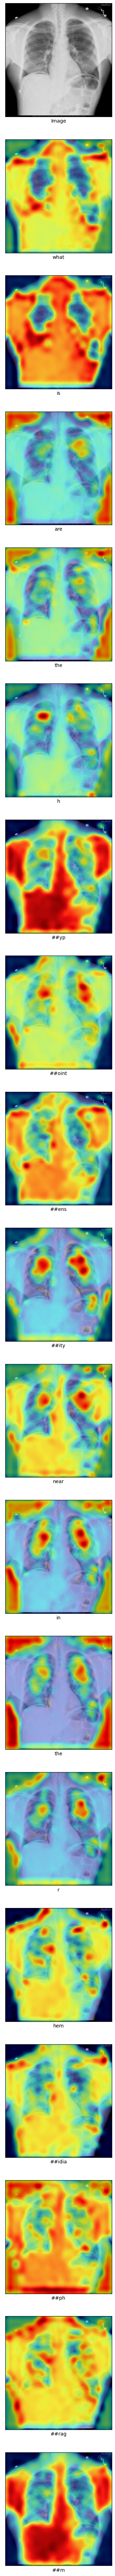

In [119]:
num_image = len(text_input.input_ids[0]) 
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
            
for i,token_id in enumerate(text_input.input_ids[0][1:]):
    word = tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, gradcam[i+1])
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


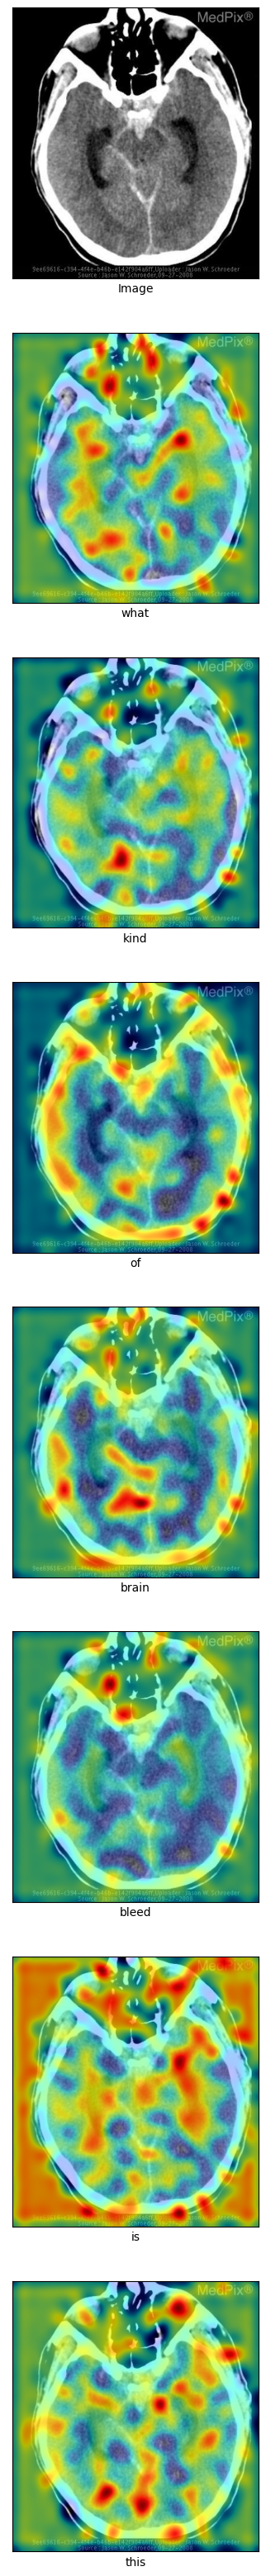

In [167]:
import json
q_str = '{"qid": 1271, "image_name": "synpic45914.jpg", "image_organ": "HEAD", "answer": "Subarachnoid", "answer_type": "OPEN", "question_type": "PRES", "question": "What kind of brain bleed is this?", "phrase_type": "freeform"}'

q_dict = json.loads(q_str)
image_path = '/mnt/sda/lpf/data/vqa/data_RAD/images/'+q_dict['image_name']
caption = q_dict['question']


image_pil = Image.open(image_path).convert('RGB')
image = transform(image_pil).unsqueeze(0)

text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")

if use_cuda:
    image = image.cuda()
    text_input = text_input.to(image.device)

output = model(image, text_input)
loss = output[:,1].sum()

model.zero_grad()
loss.backward()

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()
num_image = len(text_input.input_ids[0])
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")

for i,token_id in enumerate(text_input.input_ids[0][1:]):
    word = tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, gradcam[i+1])
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)